# Solution for Homework 2

In [2]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Below are functions that we "borrow" from the notebook usd in class 

### Copy functions from Class Notebook

In [3]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [6]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [7]:
def half_sine_pulse(fsT):
    """Generate a pulse that is shaped like a half cycle of a sinusoid
    
    Inputs:
    fsT - number of samples per symbol period

    Returns:
    Numpy array with fsT+1 samples (the sample at time t=T is included)
    """

    tt = np.arange(fsT+1) / fsT
    return np.sqrt(2/fsT) * np.sin(np.pi*tt)


## Solution for Problem 2

**Problem Statement:** The
notebook from class 2 concluded with an example that showed how
to perform a Monte Carlo Simulation to estimate the symbol error
rate for a single SNR value. Since this is a symbol error
simulation, define SNR to be the ratio of symbol energy $E_s$ to
noise power spectral density $N_0$. 

1. Expand this simulation to cover the range of SNR values from 5dB to 15dB (in 1dB steps).
2. Compute the exact symbol error probability for the QPSK signal set over this range of SNRs.
3. Plot both the exact and the simulated error rate; use a logarithmic scale for the error probability and indicate 95% confidence intervals on the plot for the simulated error rate.

In [19]:
# Simulation Parameters
fsT = 8
pp = half_sine_pulse(fsT)   # this is normalized to unit energy
SNR_dB = np.arange(5., 16.)   # range of dB values

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = 1024                    # number of symbols per burst

# simulation parameters
max_bursts = 1000
max_errors = 400

## storage for results
num_errors = np.zeros_like(SNR_dB, dtype=int)
num_symbols = np.zeros_like(num_errors)

P_exact = np.zeros_like(SNR_dB)
P_MC = np.zeros_like(SNR_dB)
sc = np.zeros_like(P_MC)

In [28]:
## the Monte Carlo loop; first over SNR
for n in range(len(SNR_dB)):
    N_bursts = 0
    N_errors = 0
    SNR = 10**(SNR_dB[n]/10)

    # then repeat until we have enough errors
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = pulse_shape(sym, pp, fsT)
    
        # Channel
        rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, A)

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    # done with this SNR; store results for this SNR
    num_errors[n] = N_errors
    num_symbols[n] = N*N_bursts
    P_MC[n] = num_errors[n]/num_symbols[n]
    sc[n] = 1.96 * np.sqrt(P_MC[n] * (1 - P_MC[n]) / num_symbols[n])
    P_exact[n] = 2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2

    # show results for this SNR
    # print("SNR = {:4.1f} dB".format(SNR_dB[n]))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(num_errors[n], num_symbols[n], P_MC[n]))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(P_exact[n]))

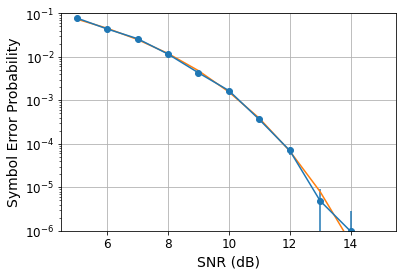

In [29]:
plt.errorbar(SNR_dB, P_MC, yerr=sc, fmt='-o', label="Monte Carlo")
plt.plot(SNR_dB, P_exact, label='Exact')

plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Probability')
plt.yscale('log')
plt.ylim([1e-6, 1e-1])

plt.show()

## Solution for Problem 3

Look up the 16APSK constellation in the
DVB-S2 standard (Figure 11 and Table 9 on page 27).
    
1. Consider $\gamma=2.5$, find the nearest neighbor approximation for the (uncoded) symbol error
rate. For what SNR (i.e., $E_s/N_0$) value $\text{SNR}_0$ is the symbol error rate equal to
$10^{-3}$?
2. Simulate the symbol error rate, over a range of SNR values
from $\text{SNR}_0 - 5\text{dB}$ to $\text{SNR}_0 + 3\text{dB}$. Plot the results with a lograrithmic
y-axis and errorbars to indicate confidence intervals. Show the
nearest neighbor approximation for comparison.
3. Expand your simulation to measure *bit error rates*
instead of symbol error rates. Use the bit mapping indicated in
the standard and define SNR to be the ratio of bit energy $E_b$
to noise power spectral density.

**Answer:** We begin by defining the 16APSK constellation. The ratio $\gamma = \frac{r_2}{r_1}$ is sspecified as 2.5. Additionally, we choose to normalize the constellation such that the average symbol energy $E_s=1$. This leads to the requirement that
$$
E_s = \frac{1}{16} (4 r_1^2 + 12 r_2^2) = \frac{r_1^2}{16}(4 + 12\gamma^2) = 1.
$$
Thus, the two radii can be uniquely determined as shown below.

To capture the mapping of 4-bit patterns to symbols, we define a dictionary with the 4-bit patterns as keys and the constellation pint as values. The 4-bit patterns are specified in binary form (e.g., `0b1001`) but they represent integers between 0 and 15. It is useful, to derive from the dictionary an array of constellation points sorted by the 4-bit patterns, i.e., the constellation point for `0b0000` comes first, then `0b0001`, and finally `0b1111`.

In [52]:
# figure out the parameters of the constellation
gamma = 2.5
r1 = np.sqrt(16/(4+12*gamma**2))
r2 = gamma*r1

# define the constellation as a dictionary
APSK16 = {
    # inner ring
    0b1100: r1 * np.exp(1j*1*np.pi/4),
    0b1110: r1 * np.exp(1j*3*np.pi/4),
    0b1111: r1 * np.exp(1j*5*np.pi/4),
    0b1101: r1 * np.exp(1j*7*np.pi/4),
    # outer ring
    0b0100: r2 * np.exp(1j*1*np.pi/12),
    0b0000: r2 * np.exp(1j*3*np.pi/12),
    0b1000: r2 * np.exp(1j*5*np.pi/12),
    0b1010: r2 * np.exp(1j*7*np.pi/12),
    0b0010: r2 * np.exp(1j*9*np.pi/12),
    0b0110: r2 * np.exp(1j*11*np.pi/12),
    0b0111: r2 * np.exp(1j*13*np.pi/12),
    0b0011: r2 * np.exp(1j*15*np.pi/12),
    0b1011: r2 * np.exp(1j*17*np.pi/12),
    0b1001: r2 * np.exp(1j*19*np.pi/12),
    0b0001: r2 * np.exp(1j*21*np.pi/12),
    0b0101: r2 * np.exp(1j*23*np.pi/12),
}

# construct an array of constellation points sorted by the 4-bit patterns
A_APSK16 = np.array([APSK16[n] for n in range(16)])

We will also need a function for looking up the 4-bit pattern for a given constellation point. Here is a function to do that.

In [69]:
def get_bits(x, A):
    """look-up the bit pattern for the closest constellation point
    
    Inputs:
    x - observed constellation point
    A - constellation sorted by bit pattern

    Returns
    bit pattern represented as an integer
    """ 
    return np.argmin(np.abs(A - x))

Our first task is to obtain an estimate of the symbol error rate via the nearest neighbor approximation. For that approximation, we must find the minimum distance between any pair of constellation points.

From the constellation diagram, it is readily apparent that there are three candidate pairs for the minimum distance:
1. adjacent points on the inner circle, e.g., `0b1100` and `0b1101`: the distance between such points is $d_1=2r_1 \sin(\pi/4)=\sqrt(2) \cdot r_1$.
2. adjacent points on the outer circle, e.g., `0b0100`and `0b01011: the distance between such points is 
$$
d_2 = 2r_2 \sin(\pi/12)=\frac{\sqrt{6}-\sqrt{2}}{2} \cdot r_2 = \frac{\sqrt{6}-\sqrt{2}}{2} \gamma \cdot r_1.
$$
3. points on inner and outer rings located on a diagonal, e.g., `0b1100` and `0b000`: the distance between such pairs is $d_3=r_2-r_1=(\gamma-1)\cdot r_1$

For $gamma=2.5$, we have $d_2 < d_1 < d_3$ and $d_{min} = d_2$.

We can now compute the energy efficiency $\eta$ for this constellation,
$$
    \eta = \frac{d_{min}^2}{E_b} = \frac{d_2^2}{E_s/4} = 4 d_2^2.
$$

Finally, we need the average number $N_{min}$ of neighbors at distance $d_{min}$. The twelve points on the outer ring each have two neighbors at distance $d_2$ and the four points on the inner ring have no neighbors at that distance. Hence,
$$
N_{min} = \frac{1}{16}(12 \cdot 2 + 4 \cdot 0) = \frac{3}{2}.
$$

The nearest neighbor approximatin to the symbol error probability is
$$
    P_e \approx N_{min} \cdot Q\left( \sqrt{\frac{\eta E_b}{2N_0}}\right) = N_{min} \cdot Q\left( \sqrt{\frac{\eta E_s/4}{2N_0}}\right)
$$

Let's plot the nearest neighbor approximation so that we can determnine for what $E_s/N_0$ the symbol error rate is approximately $10^-3$.

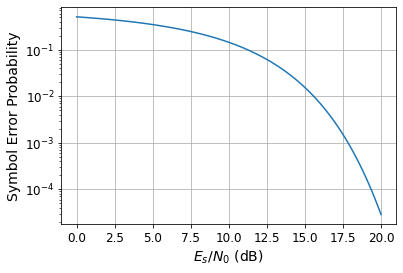

In [56]:
# find d_min, eta, etc.
d2 = 2*r2*np.sin(np.pi/12)
eta = 4*d2**2
N_min = 3/2

# compute the nearest neighbor approximation
SNR = np.logspace(0, 2, 100)
Pe_NN = N_min * Q(np.sqrt(eta*SNR/4/2))

# and plot it
plt.semilogy(10*np.log10(SNR), Pe_NN)
plt.grid()
plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('Symbol Error Probability')

plt.show()

From the plot above, we can read off that $E_s/N_0$ must be approximately 17.5dB to yields a symbol error rate of $10^{-3}$.

Before running the Monte Carlo simulation, we need one more tool. We need to be able to count the number of bit differences in one symbol. Specifically, we need a function that counts in how many bit positions two integers differ. The function below does that.

In [58]:
def d_hamming(x, y):
    """compute the hamming disatnce between bit vectors 
    
    The bit vectors are represented by integers x and y

    Inputs:
    x - integer representing the first bit vector
    y - integer representing the second bit vector

    Returns:
    Number of bit differences between x and y
    """
    diff = x ^ y # bit-wise xor of x and y

    n_diff = 0

    while diff != 0:
        n_diff += diff & 0b1
        diff = diff >> 1

    return n_diff

In [60]:
# spot check that this is working correctly
assert d_hamming(0b1010, 0b1000) == 1
assert d_hamming(0b1010, 0b0000) == 2
assert d_hamming(0b1010, 0b0101) == 4
assert d_hamming(0b1010, 0b1010) == 0

We now have all the required tool and information for the simulation.

We define the simulation parameters and then run the simulation.

In [76]:
# Simulation Parameters
fsT = 8
pp = half_sine_pulse(fsT)   # this is normalized to unit energy
SNR_dB = np.arange(17.5-5, 17.5+3.1, 0.5)   # range of dB values

A = A_APSK16                # use the 16APSK constellation from above
N = 1024                    # number of symbols per burst

# simulation parameters
max_bursts = 1000
max_errors = 400

## storage for results
num_sym_errors = np.zeros_like(SNR_dB, dtype=int)
num_bit_errors = np.zeros_like(SNR_dB, dtype=int)
num_symbols = np.zeros_like(num_sym_errors)
num_bits = np.zeros_like(num_bit_errors)

P_NN = np.zeros_like(SNR_dB)
P_MC_sym = np.zeros_like(SNR_dB)
P_MC_bit = np.zeros_like(SNR_dB)
sc_sym = np.zeros_like(SNR_dB)
sc_bit = np.zeros_like(SNR_dB)

In [78]:
## the Monte Carlo loop; first over SNR
for n in range(len(SNR_dB)):
    N_bursts = 0
    N_sym_errors = 0
    N_bit_errors = 0
    SNR = 10**(SNR_dB[n]/10)

    # then repeat until we have enough errors
    while N_bursts < max_bursts and N_sym_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = pulse_shape(sym, pp, fsT)
    
        # Channel
        rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, A)

        # update simulation statistics
        N_bursts += 1
        N_sym_errors += np.sum(np.not_equal(dec, sym))
        for m in range(N):
            if dec[m] != sym[m]:
                N_bit_errors += d_hamming(get_bits(sym[m], A), get_bits(dec[m], A))

    # done with this SNR; store results for this SNR
    num_sym_errors[n] = N_sym_errors
    num_bit_errors[n] = N_bit_errors
    num_symbols[n] = N*N_bursts
    num_bits[n] = 4*N*N_bursts
    P_MC_sym[n] = num_sym_errors[n]/num_symbols[n]
    P_MC_bit[n] = num_bit_errors[n]/num_bits[n]
    sc_sym[n] = 1.96 * np.sqrt(P_MC_sym[n] * (1 - P_MC_sym[n]) / num_symbols[n])
    sc_bit[n] = 1.96 * np.sqrt(P_MC_bit[n] * (1 - P_MC_bit[n]) / num_bits[n])
    P_NN[n] = N_min * Q(np.sqrt(eta*SNR/4/2))

    # show results for this SNR
    # print("SNR = {:4.1f} dB".format(SNR_dB[n]))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(num_sym_errors[n], num_symbols[n], P_MC_sym[n]))
    # print("The approximate symbol error rate is: {:8.6f}".format(P_NN[n]))

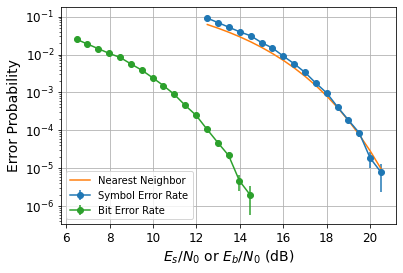

In [82]:
plt.errorbar(SNR_dB, P_MC_sym, yerr=sc_sym, fmt='-o', label="Symbol Error Rate")
plt.plot(SNR_dB, P_NN, label='Nearest Neighbor')

# for bit error rate, x-axis should be Eb/N0; divide Es/N0 by 4
plt.errorbar(SNR_dB - 10*np.log10(4), P_MC_bit, yerr=sc_bit, fmt='-o', label="Bit Error Rate")

plt.grid()
plt.xlabel('$E_s/N_0$ or $E_b/N_0$ (dB)')
plt.ylabel('Error Probability')
plt.yscale('log')
plt.legend()
#plt.ylim([1e-6, 1e-1])

plt.show()